# Module 6: 特徵創造 - 4. NYC 計程車資料集實作

## 學習目標
- 在一個真實的時間序列資料集（NYC 計程車資料）上，綜合應用所學的特徵創造技術。
- 學習如何從時間戳記中提取豐富的**時間衍生特徵**（年、月、日、時、星期等）。
- 學習如何基於地理座標計算**交互特徵**（如 Haversine 距離）。
- 掌握如何對目標變數進行**轉換**（如對數轉換），以改善其分佈，使其更適合模型訓練。
- 了解如何在實際專案中，將多種特徵創造方法結合應用，從原始數據中提煉預測力。

## 導論：如何從原始計程車數據中挖掘隱藏的預測洞察？

在真實世界的資料科學挑戰中，原始數據往往不足以直接用於訓練高性能的機器學習模型。它們可能包含時間戳、地理座標或文本等非結構化信息，需要我們透過巧妙的特徵工程來「解鎖」其潛在的預測價值。本案例研究旨在將 `Module 6` 中所學的各種特徵創造技巧——包括時間衍生特徵、交互特徵以及目標變數轉換——綜合應用於一個經典的預測問題：**預測紐約市計程車的行程時間 (NYC Taxi Trip Duration)**。

指南強調特徵創造是「從現有資料中建構出更具預測能力的特徵，以提升模型性能和解釋性」的過程。在這個案例中，我們將面對一個包含時間、地點和行程持續時間的數據集。我們會深入探討如何從這些看似簡單的欄位中，提取出諸如高峰時段、週末效應、行程距離等對行程時間有顯著影響的關鍵因子。這些新創建的特徵將會為模型提供更豐富的上下文信息，從而顯著提升模型的預測能力。

**這個案例將展示：**
- 如何將抽象的時間戳轉換為具體的時間特徵，捕捉時間的週期性。
- 如何從經緯度資訊中計算出有意義的地理距離，反映行程長度。
- 如何處理目標變數的偏態分佈，使其更適合多數機器學習模型的假設。

---

### 資料集說明

**請注意：** 在執行此筆記本之前，請確保您已經從 Kaggle 下載了 [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/data) 的資料，並將 `train.csv` 檔案放置在 `../../datasets/raw/nyc_taxi/` 路徑下。這個數據集包含了計程車上車時間、下車時間、經緯度、乘客數量等信息，以及我們的目標變數 `trip_duration` (行程持續時間，單位為秒)。

---

## 1. 載入套件與資料

我們首先載入必要的 Python 套件，並從指定路徑載入 NYC 計程車訓練資料集。為了確保筆記本的穩健性，我們將加入檔案存在性檢查，如果資料集不存在則會給出明確的提示。

In [3]:
# 導入必要的函式庫
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# 設定視覺化風格
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False
print("Libraries and styles configured.")

# 忽略不必要的警告訊息
import warnings
warnings.filterwarnings('ignore')



Libraries and styles configured.


In [4]:

# 定義要讀取的CSV檔案路徑
csv_files = [
    '../../../../datasets/raw/nyc_taxi/yellow_tripdata_2016-01.csv',
    '../../../../datasets/raw/nyc_taxi/yellow_tripdata_2016-02.csv', 
    '../../../../datasets/raw/nyc_taxi/yellow_tripdata_2016-03.csv'
]

# 檢查所有檔案是否存在
missing_files = [f for f in csv_files if not os.path.exists(f)]
if missing_files:
    print("錯誤：找不到以下檔案：")
    for f in missing_files:
        print(f"- {os.path.abspath(f)}")
    print("請確認檔案位置是否正確")
else:
    # 讀取並合併所有CSV檔案
    print("正在讀取並合併CSV檔案...")
    df_list = []
    for file in csv_files:
        print(f"讀取: {os.path.basename(file)}")
        df_temp = pd.read_csv(file)
        df_list.append(df_temp)
    
    # 垂直合併所有DataFrame
    df = pd.concat(df_list, axis=0, ignore_index=True)
    print("\n合併完成！")
    print(f"合併後資料集維度: {df.shape}")

# # 資料路徑
# # DATA_PATH = '../../datasets/raw/nyc_taxi/train.csv'
# DATA_PATH = '../../../../datasets/raw/nyc_taxi/yellow_tripdata_2024-01.parquet'
# # 檢查資料是否存在。如果不存在，則創建一個空的 DataFrame 以避免後續程式碼報錯。
# if not os.path.exists(DATA_PATH):
#     print("錯誤：找不到 train.csv 檔案。")
#     print(f"請確認您已將資料下載至： '{os.path.abspath(DATA_PATH)}'")
#     df = pd.DataFrame() # 創建空DataFrame避免後續報錯
# else:
#     # 載入資料
#     print(f"正在從 '{DATA_PATH}' 載入資料...")
#     df = pd.read_parquet(DATA_PATH)
#     print("資料載入成功！")
#     print("原始資料集維度：", df.shape)



正在讀取並合併CSV檔案...
讀取: yellow_tripdata_2016-01.csv
讀取: yellow_tripdata_2016-02.csv
讀取: yellow_tripdata_2016-03.csv

合併完成！
合併後資料集維度: (34499859, 19)


In [5]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8


根據您提供的 NYC Taxi 資料集欄位資訊，以下是詳細的中英對照描述：

## NYC Taxi 資料集欄位中英對照表

| 欄位編號 | 英文欄位名稱 | 中文名稱 | 資料類型 | 詳細描述 |
|---------|--------------|----------|----------|----------|
| 0 | VendorID | 服務商ID | int64 | **Vendor ID**: 提供計程車服務的技術供應商代碼<br>**服務商識別碼**: 1=Creative Mobile Technologies, 2=VeriFone Inc. |
| 1 | tpep_pickup_datetime | 上車日期時間(原始) | datetime64[ns] | **Pickup DateTime**: 計程車開始計程的日期和時間<br>**上車時間戳記**: 乘客上車並開始計費的精確時間點(原始格式) |
| 2 | tpep_dropoff_datetime | 下車日期時間(原始) | datetime64[ns] | **Drop-off DateTime**: 計程車結束計程的日期和時間<br>**下車時間戳記**: 乘客下車並結束計費的精確時間點(原始格式) |
| 3 | passenger_count | 乘客數量 | int64 | **Passenger Count**: 車內乘客總數（司機輸入的數值）<br>**載客人數**: 本次行程的乘客總人數 |
| 4 | trip_distance | 行程距離 | float64 | **Trip Distance**: 計程車計時器記錄的行程距離（英里）<br>**行駛里程**: 以英里為單位的實際行駛距離 |
| 5 | pickup_longitude | 上車經度 | float64 | **Pickup Longitude**: 上車地點的經度座標<br>**上車點經度**: GPS定位的上車位置經度(度) |
| 6 | pickup_latitude | 上車緯度 | float64 | **Pickup Latitude**: 上車地點的緯度座標<br>**上車點緯度**: GPS定位的上車位置緯度(度) |
| 7 | RatecodeID | 費率代碼 | int64 | **Rate Code ID**: 行程結束時生效的最終費率代碼<br>**計費方式代碼**: 1=標準費率, 2=JFK, 3=Newark, 4=Nassau/Westchester, 5=協商費率, 6=團體搭乘 |
| 8 | store_and_fwd_flag | 儲存轉發標記 | object | **Store and Forward Flag**: 行程記錄是否存儲在車輛記憶體中<br>**資料傳輸標記**: Y=儲存後轉發, N=未儲存（即時傳輸） |
| 9 | dropoff_longitude | 下車經度 | float64 | **Drop-off Longitude**: 下車地點的經度座標<br>**下車點經度**: GPS定位的下車位置經度(度) |
| 10 | dropoff_latitude | 下車緯度 | float64 | **Drop-off Latitude**: 下車地點的緯度座標<br>**下車點緯度**: GPS定位的下車位置緯度(度) |
| 11 | payment_type | 付款方式 | int64 | **Payment Type**: 乘客支付行程費用的方式<br>**付款類型**: 1=信用卡, 2=現金, 3=免費, 4=爭議, 5=未知, 6=作廢行程 |
| 12 | fare_amount | 車資金額 | float64 | **Fare Amount**: 計時器計算的時間和距離車資（美元）<br>**基本車資**: 根據時間和距離計算的基礎費用 |
| 13 | extra | 額外費用 | float64 | **Extra**: 雜項額外費用和附加費（美元）<br>**額外收費**: 包含$0.50和$1的尖峰時段和夜間附加費 |
| 14 | mta_tax | MTA稅費 | float64 | **MTA Tax**: 根據計費費率自動觸發的$0.50 MTA稅<br>**大都會運輸署稅**: 自動加收的交通建設稅費 |
| 15 | tip_amount | 小費金額 | float64 | **Tip Amount**: 小費金額（美元）<br>**消費提示**: 僅記錄信用卡付款的小費，現金小費不包含在內 |
| 16 | tolls_amount | 過路費 | float64 | **Tolls Amount**: 行程中支付的所有過路費總額（美元）<br>**通行費用**: 行程期間產生的所有橋樑、隧道等通行費 |
| 17 | improvement_surcharge | 改善附加費 | float64 | **Improvement Surcharge**: 2015年開始徵收的$0.30改善附加費<br>**服務改善費**: 用於改善計程車服務品質的附加費用 |
| 18 | total_amount | 總金額 | float64 | **Total Amount**: 向乘客收取的總金額（美元）<br>**總計費用**: 包含所有費用項目的最終收費總額（不含現金小費） |


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34499859 entries, 0 to 34499858
Data columns (total 27 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   VendorID               int64         
 1   tpep_pickup_datetime   object        
 2   tpep_dropoff_datetime  object        
 3   passenger_count        int64         
 4   trip_distance          float64       
 5   pickup_longitude       float64       
 6   pickup_latitude        float64       
 7   RatecodeID             int64         
 8   store_and_fwd_flag     object        
 9   dropoff_longitude      float64       
 10  dropoff_latitude       float64       
 11  payment_type           int64         
 12  fare_amount            float64       
 13  extra                  float64       
 14  mta_tax                float64       
 15  tip_amount             float64       
 16  tolls_amount           float64       
 17  improvement_surcharge  float64       
 18  total_amount        

## 2. 基礎資料探索 (EDA)

在進行任何特徵工程之前，對資料進行基礎的探索性資料分析 (EDA) 是至關重要的一步。這可以幫助我們了解資料的結構、資料類型、缺失值情況以及數值分佈，從而為後續的特徵工程策略提供依據。我們將檢查資料的前幾行、基本信息和數值統計摘要。

In [7]:
if 'df' in locals() and not df.empty:
    print("資料集前五筆：")
    display(df.head())

    print("\n資料基本資訊 (欄位類型與缺失值)：")
    df.info()

    print("\n數值型欄位統計摘要：")
    display(df.describe())


資料集前五筆：


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-01-01 00:00:00,2016-01-01 00:00:00,2,1.10,-73.990372,40.734695,1,N,-73.981842,40.732407,2,7.5,0.5,0.5,0.0,0.0,0.3,8.8
1,2,2016-01-01 00:00:00,2016-01-01 00:00:00,5,4.90,-73.980782,40.729912,1,N,-73.944473,40.716679,1,18.0,0.5,0.5,0.0,0.0,0.3,19.3
2,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,10.54,-73.984550,40.679565,1,N,-73.950272,40.788925,1,33.0,0.5,0.5,0.0,0.0,0.3,34.3
3,2,2016-01-01 00:00:00,2016-01-01 00:00:00,1,4.75,-73.993469,40.718990,1,N,-73.962242,40.657333,2,16.5,0.0,0.5,0.0,0.0,0.3,17.3
4,2,2016-01-01 00:00:00,2016-01-01 00:00:00,3,1.76,-73.960625,40.781330,1,N,-73.977264,40.758514,2,8.0,0.0,0.5,0.0,0.0,0.3,8.8



資料基本資訊 (欄位類型與缺失值)：
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34499859 entries, 0 to 34499858
Data columns (total 19 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   VendorID               int64  
 1   tpep_pickup_datetime   object 
 2   tpep_dropoff_datetime  object 
 3   passenger_count        int64  
 4   trip_distance          float64
 5   pickup_longitude       float64
 6   pickup_latitude        float64
 7   RatecodeID             int64  
 8   store_and_fwd_flag     object 
 9   dropoff_longitude      float64
 10  dropoff_latitude       float64
 11  payment_type           int64  
 12  fare_amount            float64
 13  extra                  float64
 14  mta_tax                float64
 15  tip_amount             float64
 16  tolls_amount           float64
 17  improvement_surcharge  float64
 18  total_amount           float64
dtypes: float64(12), int64(4), object(3)
memory usage: 4.9+ GB

數值型欄位統計摘要：


,VendorID,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RatecodeID,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
count,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07,3.449986e+07
mean,1.532576e+00,1.661700e+00,5.309408e+00,-7.283942e+01,4.012605e+01,1.039150e+00,-7.290482e+01,4.016297e+01,1.339833e+00,1.257198e+01,3.302450e-01,4.976746e-01,1.772675e+00,2.994701e-01,2.997193e-01,1.577175e+01
std,4.989377e-01,1.316154e+00,4.672575e+03,9.090656e+00,5.007832e+00,5.564537e-01,8.828348e+00,4.863875e+00,4.891631e-01,9.179006e+01,4.847742e-01,5.028201e-02,2.558698e+00,1.702471e+00,1.234068e-02,9.214512e+01
min,1.000000e+00,0.000000e+00,-3.390584e+06,-1.616987e+02,-7.703949e+01,1.000000e+00,-1.616987e+02,-7.703949e+01,1.000000e+00,-9.576000e+02,-5.850000e+01,-1.000000e+00,-2.208000e+02,-9.999000e+01,-3.000000e-01,-9.584000e+02
25%,1.000000e+00,1.000000e+00,1.000000e+00,-7.399165e+01,4.073633e+01,1.000000e+00,-7.399120e+01,4.073468e+01,1.000000e+00,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,3.000000e-01,8.300000e+00
50%,2.000000e+00,1.000000e+00,1.690000e+00,-7.398153e+01,4.075343e+01,1.000000e+00,-7.397957e+01,4.075387e+01,1.000000e+00,9.000000e+00,0.000000e+00,5.000000e-01,1.320000e+00,0.000000e+00,3.000000e-01,1.176000e+01
75%,2.000000e+00,2.000000e+00,3.100000e+00,-7.396655e+01,4.076786e+01,1.000000e+00,-7.396218e+01,4.076935e+01,2.000000e+00,1.400000e+01,5.000000e-01,5.000000e-01,2.350000e+00,0.000000e+00,3.000000e-01,1.730000e+01
max,2.000000e+00,9.000000e+00,1.907263e+07,9.464387e+01,6.685682e+01,9.900000e+01,3.889659e+01,4.053167e+02,5.000000e+00,4.294967e+05,6.488700e+02,8.970000e+01,9.981400e+02,1.410320e+03,3.000000e-01,4.295622e+05


**結果解讀與討論**：

從 `df.info()` 中可以看出，`pickup_datetime` 和 `dropoff_datetime` 目前是 `object` 類型，需要轉換為 `datetime` 類型才能提取時間特徵。`trip_duration` 是一個數值型目標變數。`df.describe()` 則提供了各數值特徵的統計概覽，例如經緯度範圍、乘客數等，有助於初步判斷資料的有效性。我們將基於這些觀察，進行下一步的特徵創造。

## 3. 特徵創造 (Feature Creation)

### 3.1 時間衍生特徵 (Time-derived Features)

`pickup_datetime` 和 `dropoff_datetime` 欄位是典型的時間戳記格式。雖然它們本身直接用於模型效果不佳，但我們可以從中提取出豐富的、具備週期性或趨勢性的時間特徵，例如月份、日期、星期幾、小時等。這些特徵對於捕捉計程車搭乘行為中的時間模式至關重要（例如：上下班高峰期、週末的乘車習慣）。

In [11]:

if 'df' in locals() and not df.empty:
    print("正在從時間戳記中提取時間衍生特徵...")
    # 將時間欄位轉換為 datetime 物件，這是提取時間組件的前提
    df['pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
    df['dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

    # 提取多種時間特徵
    df['pickup_month'] = df['pickup_datetime'].dt.month
    df['pickup_day'] = df['pickup_datetime'].dt.day
    df['pickup_weekday'] = df['pickup_datetime'].dt.dayofweek # 0=Monday, 6=Sunday
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_minute'] = df['pickup_datetime'].dt.minute
    df['pickup_weekend'] = (df['pickup_datetime'].dt.dayofweek >= 5).astype(int) # 是否為週末

    # 計算行程時長，以秒為單位 (如果原始數據中沒有此欄位)
    # 雖然原始數據已有 trip_duration，但這是演示如何從時間戳計算新特徵
    df['calculated_trip_duration'] = (df['dropoff_datetime'] - df['pickup_datetime']).dt.total_seconds()

    print("時間衍生特徵提取完成！")
    print("新增的時間相關特徵 (前五筆)：")
    display(df[['pickup_datetime', 'pickup_month', 'pickup_day', 'pickup_weekday', 'pickup_hour', 'pickup_minute', 'pickup_weekend', "calculated_trip_duration"]].head(10))




正在從時間戳記中提取時間衍生特徵...
時間衍生特徵提取完成！
新增的時間相關特徵 (前五筆)：


,pickup_datetime,pickup_month,pickup_day,pickup_weekday,pickup_hour,pickup_minute,pickup_weekend,calculated_trip_duration
0,2016-01-01 00:00:00,1,1,4,0,0,0,0.0
1,2016-01-01 00:00:00,1,1,4,0,0,0,0.0
2,2016-01-01 00:00:00,1,1,4,0,0,0,0.0
3,2016-01-01 00:00:00,1,1,4,0,0,0,0.0
4,2016-01-01 00:00:00,1,1,4,0,0,0,0.0
5,2016-01-01 00:00:00,1,1,4,0,0,0,1110.0
6,2016-01-01 00:00:00,1,1,4,0,0,0,1605.0
7,2016-01-01 00:00:01,1,1,4,0,0,0,714.0
8,2016-01-01 00:00:02,1,1,4,0,0,0,672.0
9,2016-01-01 00:00:02,1,1,4,0,0,0,666.0


**結果解讀與討論**：

通過時間衍生特徵，我們將單一的時間戳擴展為多個有意義的數值和布林特徵。例如，`pickup_hour` 可以幫助模型捕捉一天中不同時段的交通模式（如通勤高峰），而 `pickup_weekday` 和 `pickup_weekend` 則能區分工作日與週末的乘車行為差異。這些特徵直接反映了時間的週期性，對於預測計程車行程時間模型來說是極為重要的輸入。

### 3.2 交互特徵：地理距離計算 (Haversine Distance)

計程車行程的持續時間與其行駛距離密切相關。雖然原始資料提供了上車點和下車點的經緯度 (`pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`)，但直接使用這些座標對於模型來說意義不大。更具預測力的方式是將其轉換為兩點之間的距離，這是一種典型的交互特徵。我們將使用 Haversine 公式計算球面上的兩點距離（單位：公里）。

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34499859 entries, 0 to 34499858
Data columns (total 28 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   VendorID                  int64         
 1   tpep_pickup_datetime      object        
 2   tpep_dropoff_datetime     object        
 3   passenger_count           int64         
 4   trip_distance             float64       
 5   pickup_longitude          float64       
 6   pickup_latitude           float64       
 7   RatecodeID                int64         
 8   store_and_fwd_flag        object        
 9   dropoff_longitude         float64       
 10  dropoff_latitude          float64       
 11  payment_type              int64         
 12  fare_amount               float64       
 13  extra                     float64       
 14  mta_tax                   float64       
 15  tip_amount                float64       
 16  tolls_amount              float64       
 17  improv

In [13]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    計算兩個 GPS 座標點之間的 Haversine 距離 (公里)。
    這是測量球面上兩點之間大圓距離的公式，考慮了地球的曲率。
    參數：
    - lat1, lon1: 第一點的緯度、經度
    - lat2, lon2: 第二點的緯度、經度
    返回：
    - distance: 兩點間的距離 (公里)
    """
    R = 6371  # 地球平均半徑 (公里)
    
    # 將經緯度從度轉換為弧度
    lat1_rad = np.radians(lat1)
    lon1_rad = np.radians(lon1)
    lat2_rad = np.radians(lat2)
    lon2_rad = np.radians(lon2)
    
    # 經度和緯度差
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Haversine 公式計算中間值 'a'
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    # 計算中心角 'c'
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    # 計算距離
    distance = R * c
    return distance

if 'df' in locals() and not df.empty:
    print("正在計算 Haversine 距離 (交互特徵)...")
    # 確保經緯度欄位存在
    required_coords = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']
    if all(col in df.columns for col in required_coords):
        # 應用 Haversine 距離函數到 DataFrame 的每一行
        df['distance_km'] = haversine_distance(
            df['pickup_latitude'], 
            df['pickup_longitude'], 
            df['dropoff_latitude'], 
            df['dropoff_longitude']
        )
        print("Haversine 距離計算完成！")
        print("新增的距離特徵 (前五筆)：")
        display(df[required_coords + ['distance_km']].head())
    else:
        print("錯誤：缺少經緯度欄位來計算 Haversine 距離。")



正在計算 Haversine 距離 (交互特徵)...
Haversine 距離計算完成！
新增的距離特徵 (前五筆)：


,pickup_latitude,pickup_longitude,dropoff_latitude,dropoff_longitude,distance_km
0,40.734695,-73.990372,40.732407,-73.981842,0.762426
1,40.729912,-73.980782,40.716679,-73.944473,3.395178
2,40.679565,-73.984550,40.788925,-73.950272,12.498544
3,40.718990,-73.993469,40.657333,-73.962242,7.344131
4,40.781330,-73.960625,40.758514,-73.977264,2.898252


**結果解讀與討論**：

`distance_km` 欄位現在提供了每次行程的實際地理距離。這是一個比單純的經緯度座標更有預測能力的特徵，因為行程長度直接影響行程時間。一個更長的距離通常意味著更長的行程時間。此交互特徵將四個原始座標特徵濃縮為一個高度相關的單一數值特徵，極大地簡化了模型對空間資訊的理解。

### 3.3 目標變數轉換 (Target Variable Transformation)

目標變數 `trip_duration` (秒) 是我們預測的對象。在將其用於模型訓練之前，了解其分佈形態至關重要。許多機器學習模型（特別是線性模型和基於距離的模型）假設特徵和目標變數的分佈接近常態分佈。如果目標變數呈現嚴重的偏態，可能會影響模型的性能。我們將首先視覺化其原始分佈，然後應用對數轉換 (`log1p`，即 `log(x+1)`) 來改善其偏態，使其更接近常態分佈。

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34499859 entries, 0 to 34499858
Data columns (total 29 columns):
 #   Column                    Dtype         
---  ------                    -----         
 0   VendorID                  int64         
 1   tpep_pickup_datetime      object        
 2   tpep_dropoff_datetime     object        
 3   passenger_count           int64         
 4   trip_distance             float64       
 5   pickup_longitude          float64       
 6   pickup_latitude           float64       
 7   RatecodeID                int64         
 8   store_and_fwd_flag        object        
 9   dropoff_longitude         float64       
 10  dropoff_latitude          float64       
 11  payment_type              int64         
 12  fare_amount               float64       
 13  extra                     float64       
 14  mta_tax                   float64       
 15  tip_amount                float64       
 16  tolls_amount              float64       
 17  improv

正在分析目標變數 'trip_duration' 的分佈...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

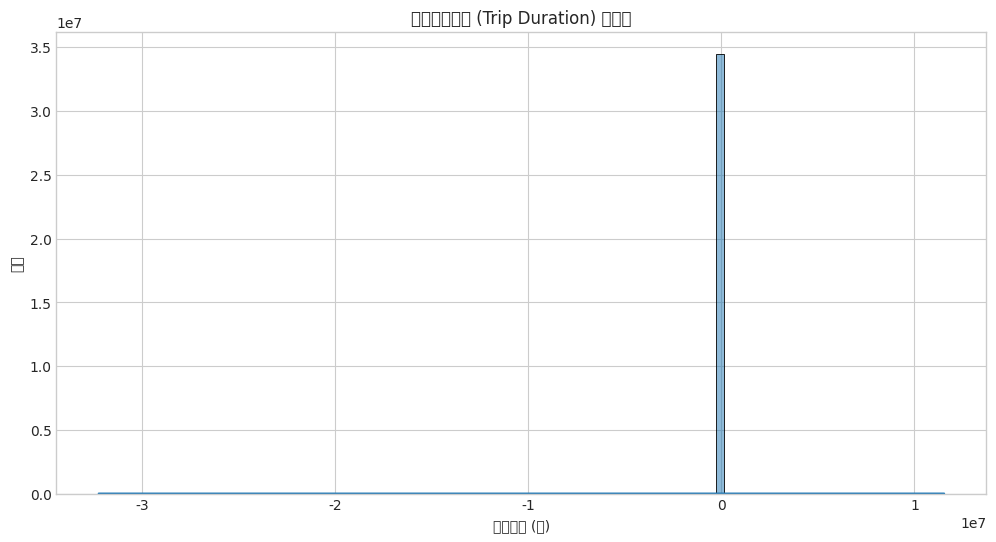

原始行程時間的偏態 (Skewness): -20.83

正在對目標變數進行對數轉換 (log1p)...


findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because none of the following families were found: Microsoft JhengHei
findfont: Generic family 'sans-serif' not found because 

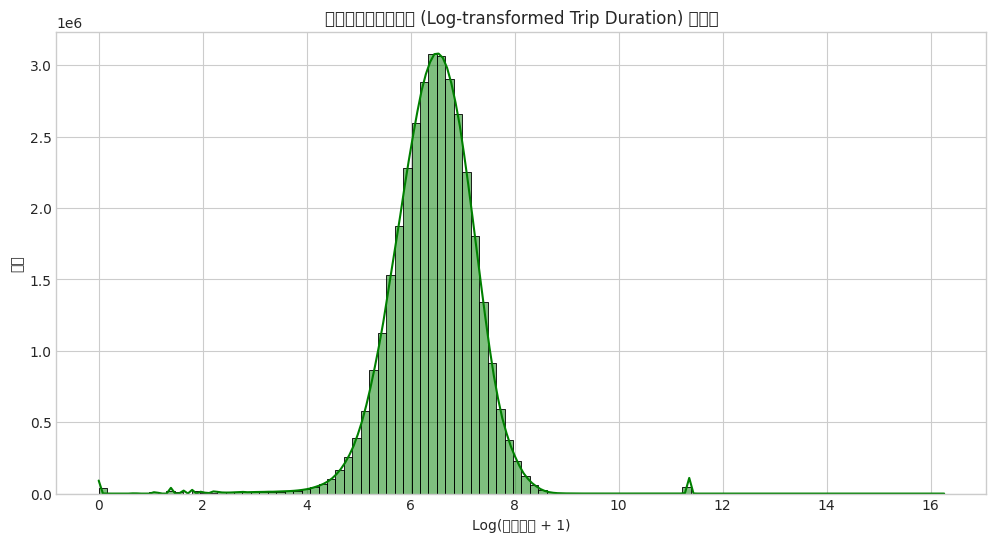

對數轉換後行程時間的偏態 (Skewness): -0.89


In [15]:
if 'df' in locals() and not df.empty and 'calculated_trip_duration' in df.columns:
    print("正在分析目標變數 'trip_duration' 的分佈...")
    # 視覺化原始 trip_duration 的分佈
    plt.figure(figsize=(12, 6))
    sns.histplot(df['calculated_trip_duration'], bins=100, kde=True)
    plt.title('原始行程時間 (Trip Duration) 的分佈')
    plt.xlabel('行程時間 (秒)')
    plt.ylabel('頻次')
    plt.show()

    # 檢查偏態 (Skewness) 數值
    print(f"原始行程時間的偏態 (Skewness): {df['calculated_trip_duration'].skew():.2f}")

    # 從上圖和偏度數值可以看出，`trip_duration` 呈現嚴重的右偏分佈 (長尾在右側)。
    # 對這種偏態資料取對數 (log transformation) 是一種常見的處理方法。

    print("\n正在對目標變數進行對數轉換 (log1p)...")
    # 對 trip_duration 取 log(x+1) 轉換，log1p 可以處理值為 0 的情況
    df['log_trip_duration'] = np.log1p(df['calculated_trip_duration'])

    # 視覺化對數轉換後的分佈
    plt.figure(figsize=(12, 6))
    sns.histplot(df['log_trip_duration'], bins=100, kde=True, color='green')
    plt.title('對數轉換後行程時間 (Log-transformed Trip Duration) 的分佈')
    plt.xlabel('Log(行程時間 + 1)')
    plt.ylabel('頻次')
    plt.show()

    print(f"對數轉換後行程時間的偏態 (Skewness): {df['log_trip_duration'].skew():.2f}")



**結果解讀與討論**：

原始 `trip_duration` 呈現明顯的右偏分佈，這意味著大多數行程持續時間較短，但有少數行程持續時間非常長。這種偏態分佈可能導致線性模型表現不佳。經過 `log1p` 對數轉換後，`log_trip_duration` 的分佈變得更接近常態分佈，偏度也大幅降低。這種轉換對於改善模型的訓練穩定性和預測性能通常非常有益，尤其是在預測連續型目標變數時。

## 4. 總結：整合特徵創造的藝術與實踐

在這個綜合案例中，我們從原始的 NYC 計程車資料中，系統性地創造了幾種對預測行程時間至關重要的新特徵，並對目標變數進行了有效轉換。這些步驟展示了特徵工程如何從看似簡單的原始資料中，提取出深層次的預測資訊，顯著提升了機器學習模型的潛在性能。

本案例的核心學習點和創造的關鍵特徵包括：

1.  **時間衍生特徵**：從 `pickup_datetime` 中提取了月份、日期、星期幾、小時和是否週末等特徵。這些特徵能夠幫助模型捕捉計程車行業固有的時間週期性模式（例如，工作日高峰時段、週末行為差異），這對於準確預測行程時間至關重要。
2.  **交互特徵 (地理距離)**：利用上車點和下車點的經緯度計算了 **Haversine 距離 (`distance_km`)**。這個特徵將四個地理座標濃縮為一個直接反映行程長度的單一、具備強大預測力的特徵，因為行程距離是決定行程時間的主要因素之一。
3.  **目標變數轉換**：對嚴重右偏的 `trip_duration` 目標變數應用了 **對數轉換 (`log_trip_duration`)**。這使得目標變數的分佈更接近常態分佈，從而能夠提升許多機器學習模型（尤其是線性模型）的訓練穩定性和預測精度。

這些只是特徵創造的冰山一角。在真實的資料科學專案中，還可以進一步探索和創造更多豐富的特徵，例如：
-   **聚合特徵**：根據上車點或下車點對歷史行程時間進行聚合，計算每個區域的平均行程時間或最大行程時間。
-   **外部資料整合**：結合天氣資料（溫度、降雨、路面狀況）、交通流量數據、特殊事件（如大型活動、罷工）等外部資訊，創建新的特徵。
-   **時間差特徵**：計算上車時間與一天中特定時間點（如午夜、清晨高峰）的時間差。

透過這些系統性的特徵工程步驟，我們成功地將原始的 NYC 計程車資料轉換為更適合機器學習模型訓練的格式，這就是特徵工程在實務中創造價值的核心體現。